In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import xgboost as xg

In [131]:
train_set = pd.read_csv('train.csv')
predict_set = pd.read_csv('test.csv')

## Some ideas yet to test
- Taking the logarithm of the outputs

## Data analysis

In [21]:
corr_matrix = train_set.corr(method='kendall')
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.669660
GarageCars       0.572168
GrLivArea        0.543942
FullBath         0.518693
GarageArea       0.478146
YearBuilt        0.470960
TotalBsmtSF      0.435018
GarageYrBlt      0.420842
YearRemodAdd     0.412955
Fireplaces       0.412829
1stFlrSF         0.411556
TotRmsAbvGrd     0.410168
OpenPorchSF      0.350161
MasVnrArea       0.321250
LotArea          0.314174
LotFrontage      0.290361
HalfBath         0.278698
WoodDeckSF       0.260349
2ndFlrSF         0.232497
BsmtFinSF1       0.220879
BedroomAbvGr     0.185607
BsmtFullBath     0.183182
BsmtUnfSF        0.127457
ScreenPorch      0.080654
3SsnPorch        0.053478
MoSold           0.049471
PoolArea         0.047800
MSSubClass      -0.003979
BsmtHalfBath    -0.009962
Id              -0.012030
YrSold          -0.021796
BsmtFinSF2      -0.030710
MiscVal         -0.050917
LowQualFinSF    -0.055308
OverallCond     -0.103492
KitchenAbvGr    -0.134718
EnclosedPorch   -0.172094
Name: SalePr

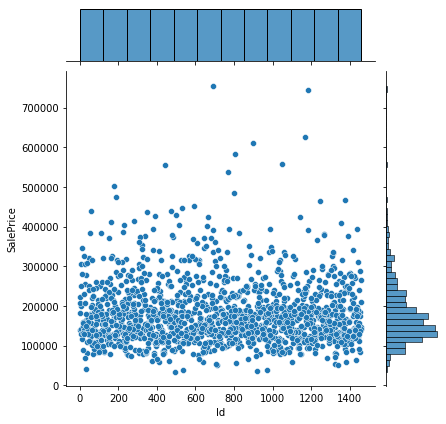

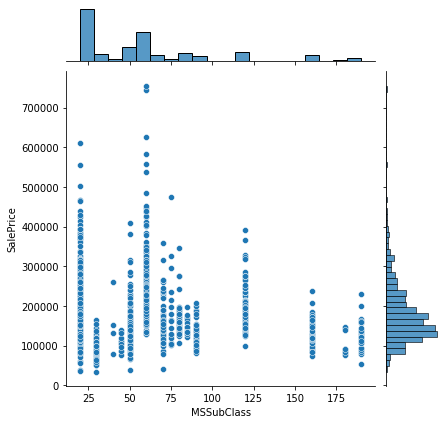

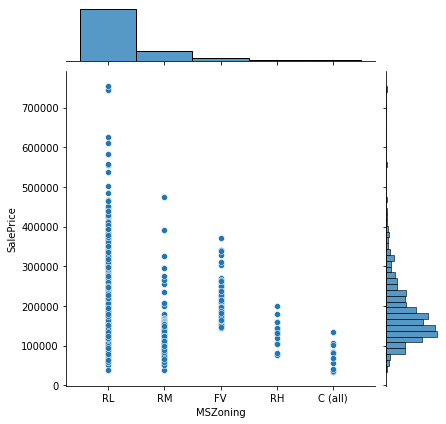

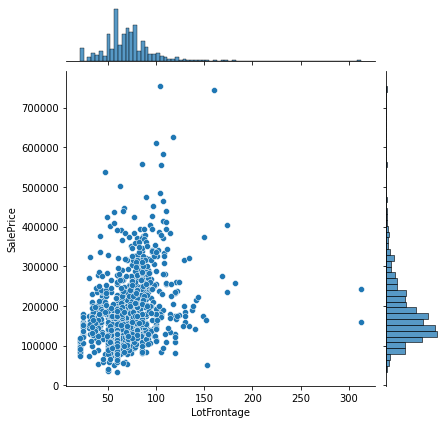

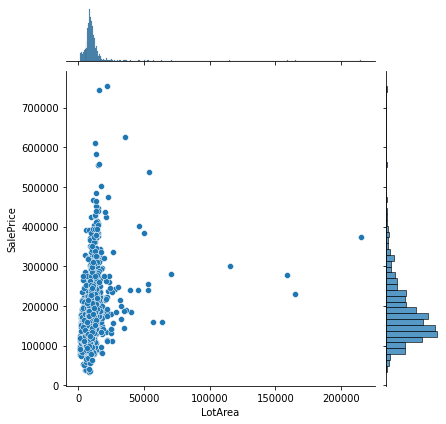

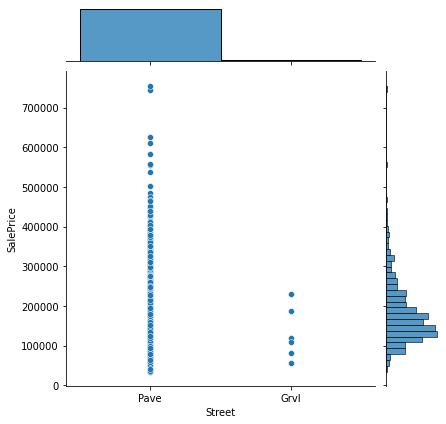

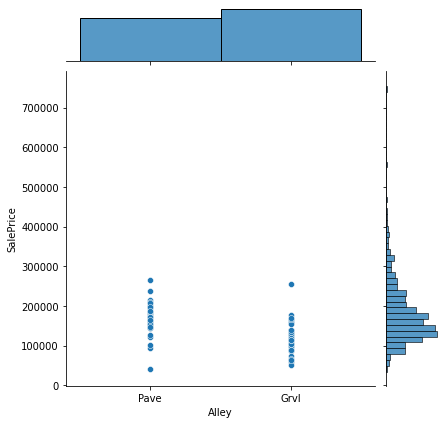

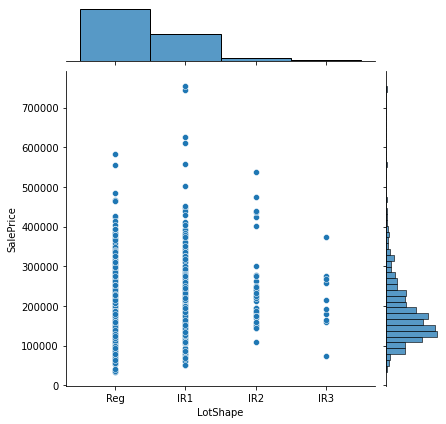

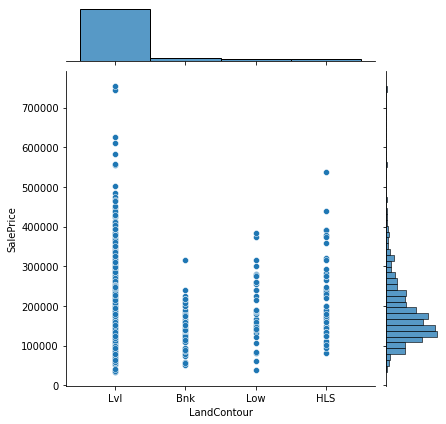

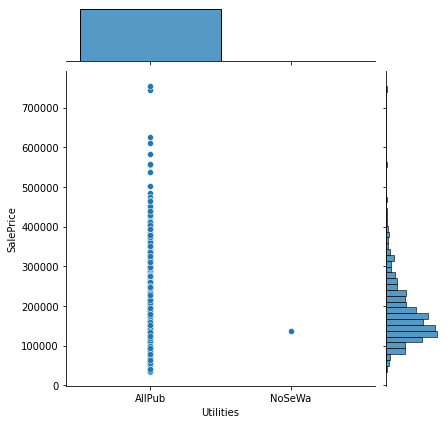

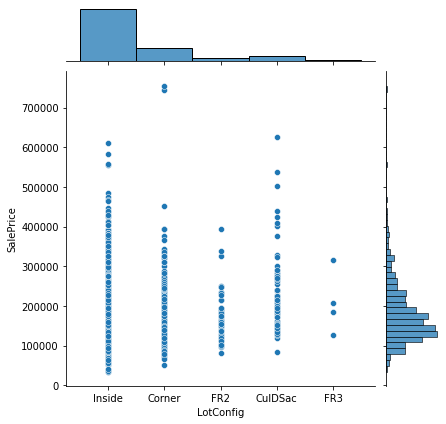

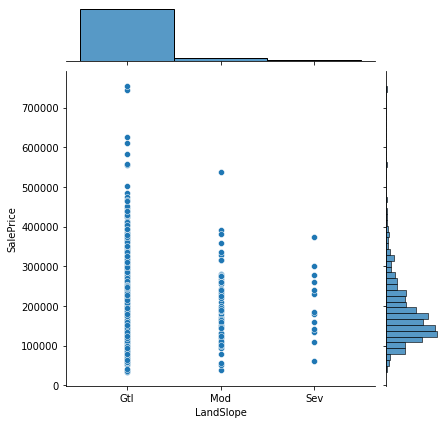

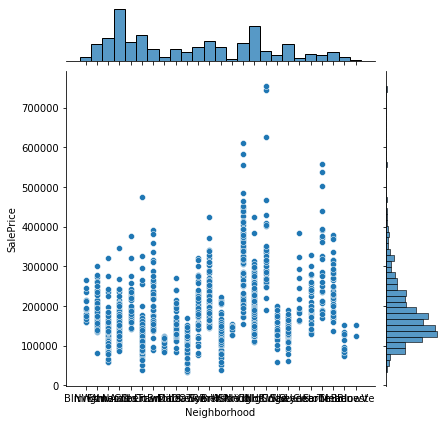

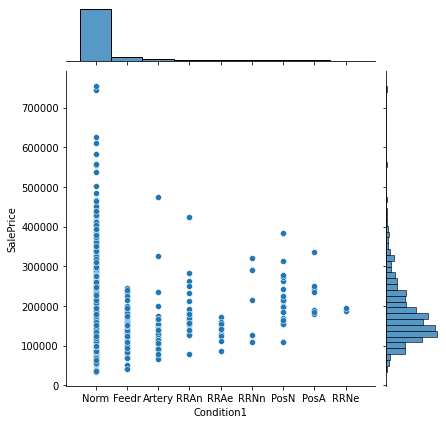

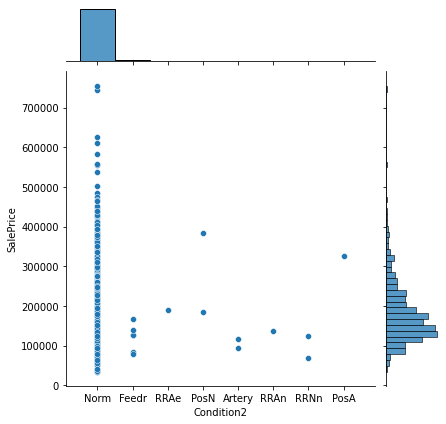

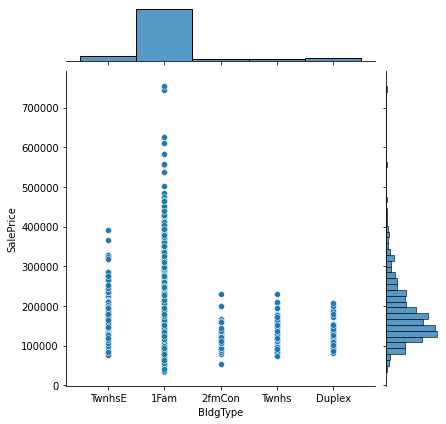

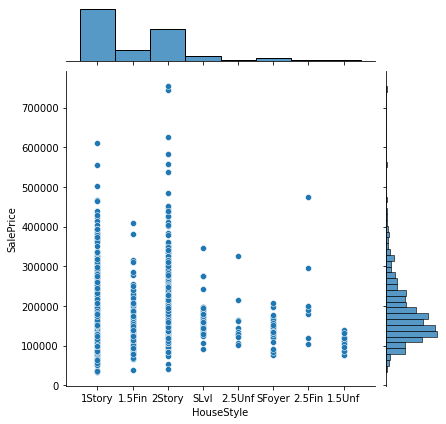

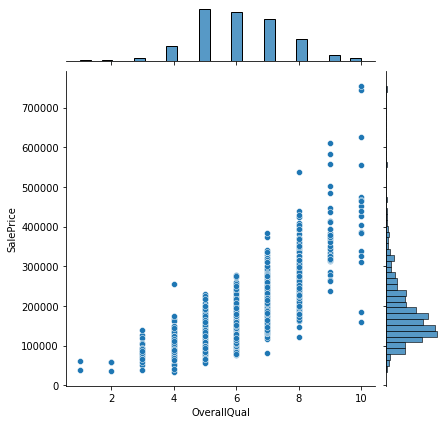

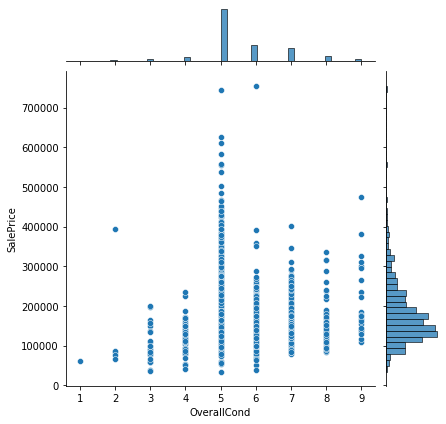

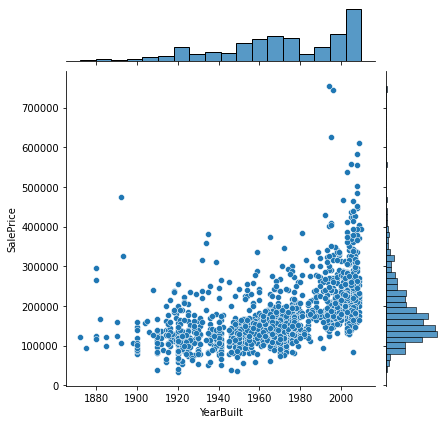

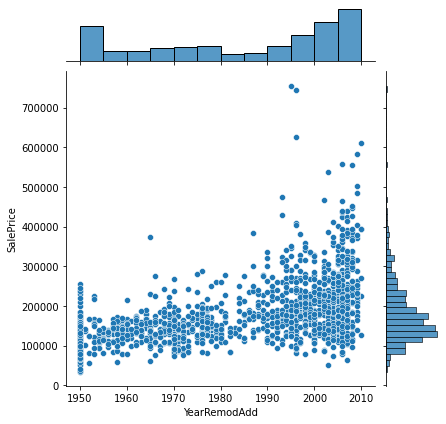

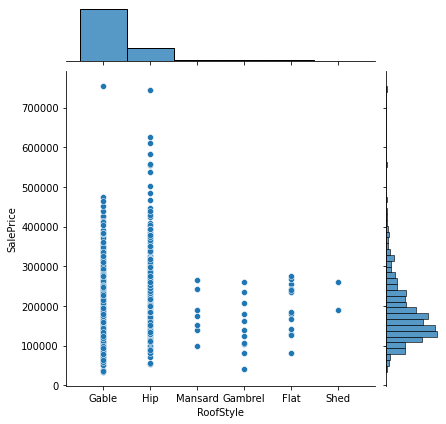

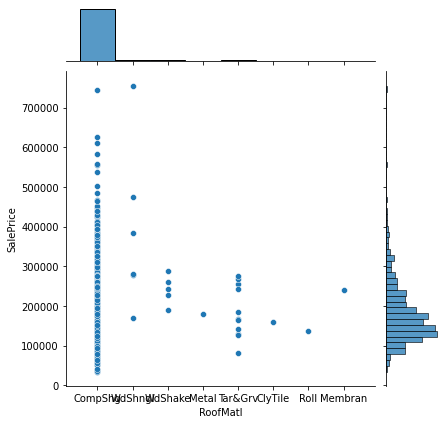

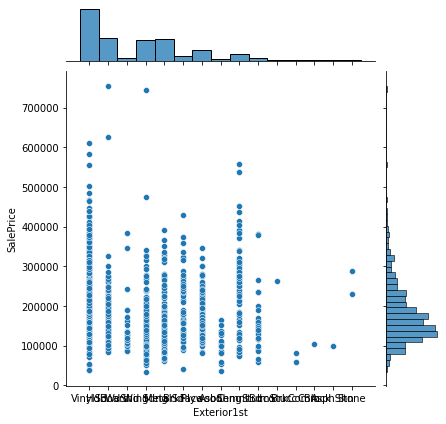

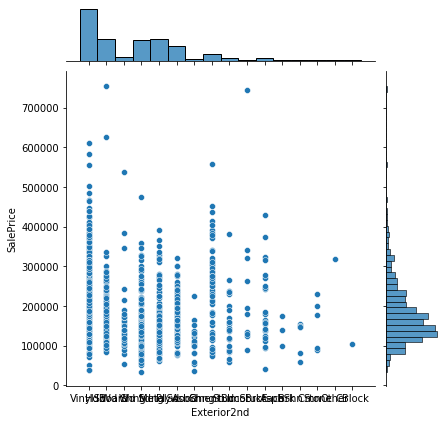

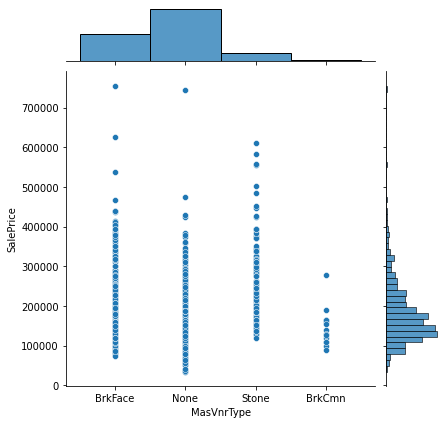

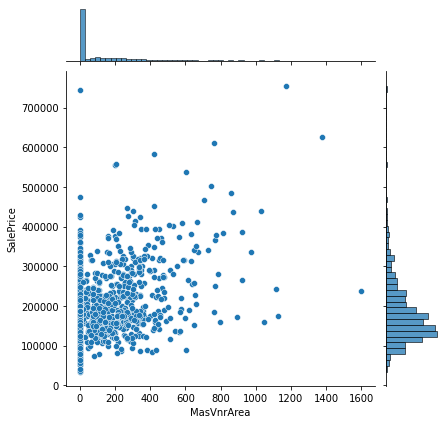

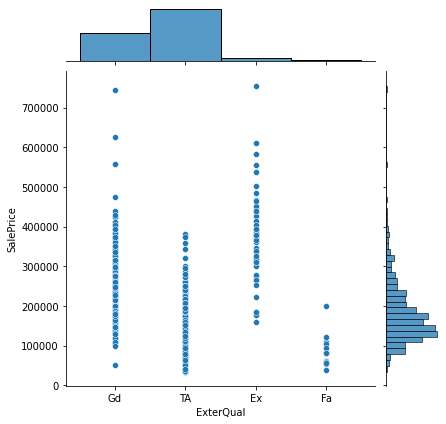

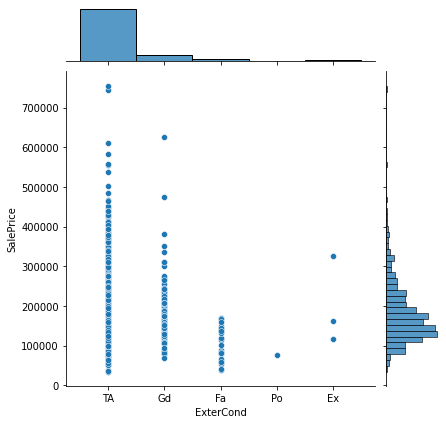

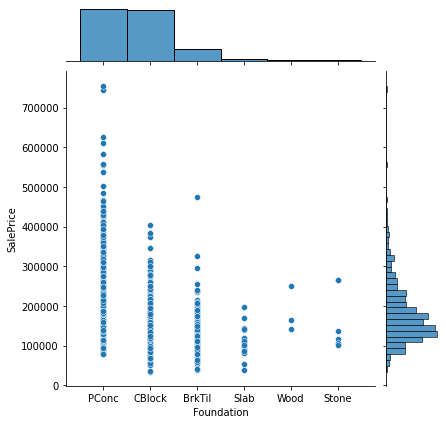

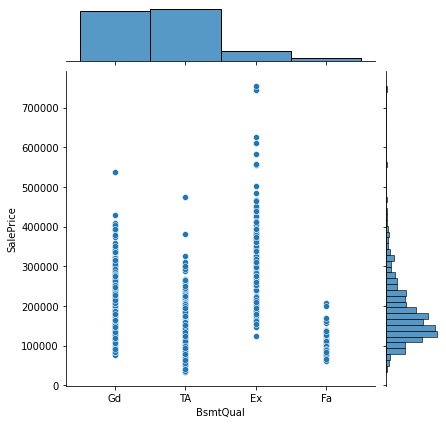

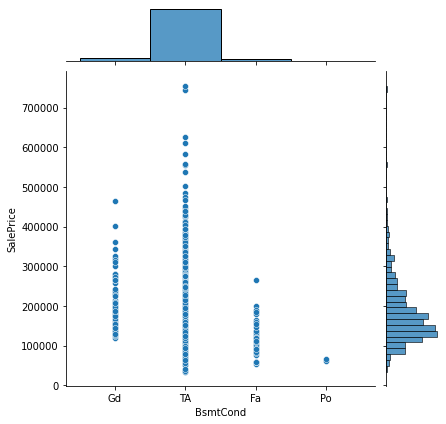

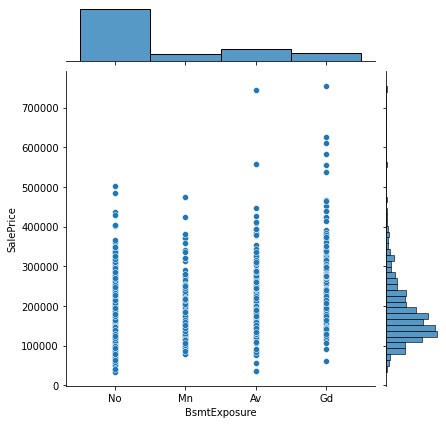

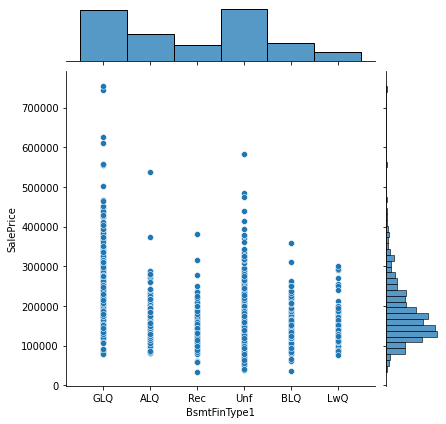

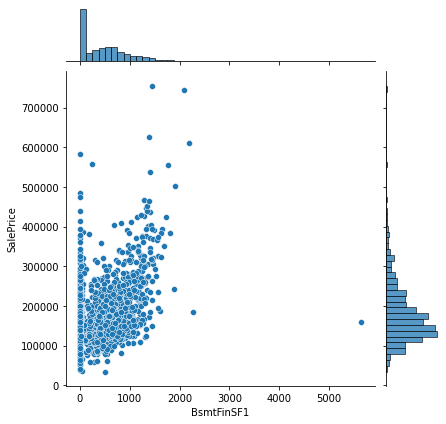

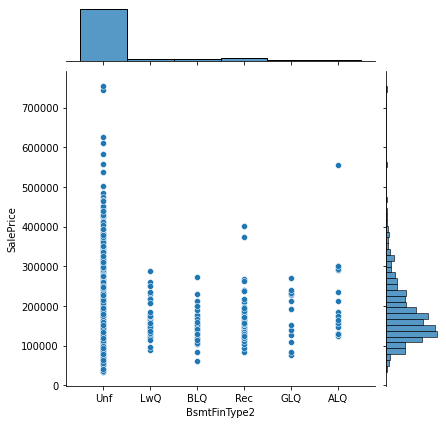

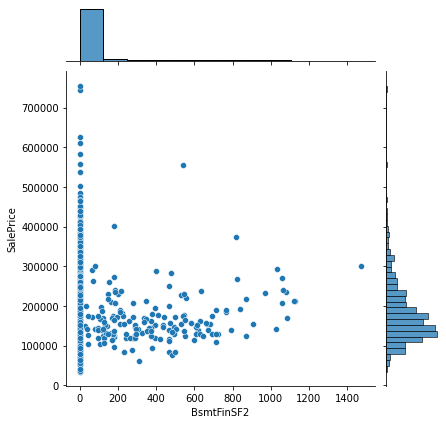

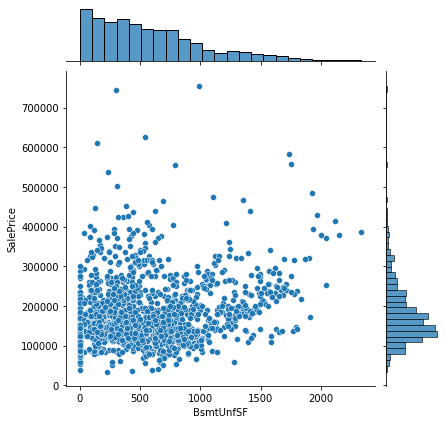

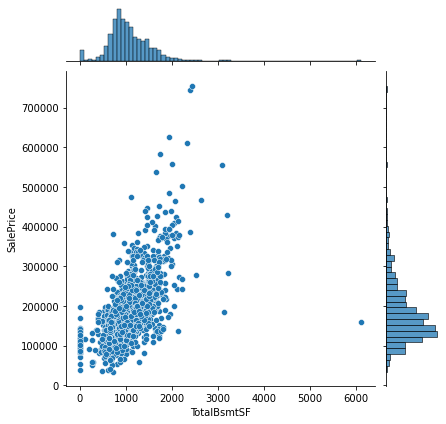

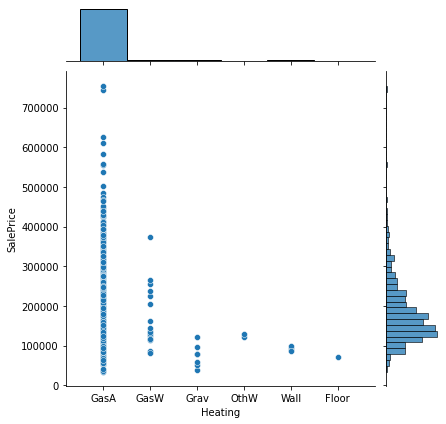

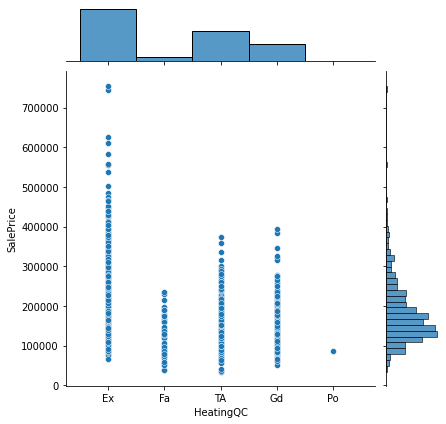

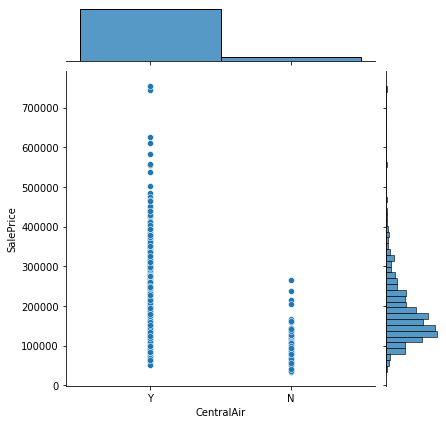

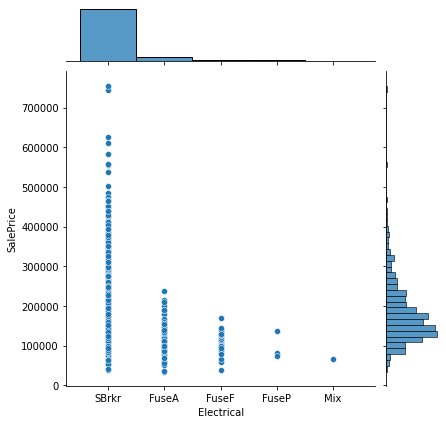

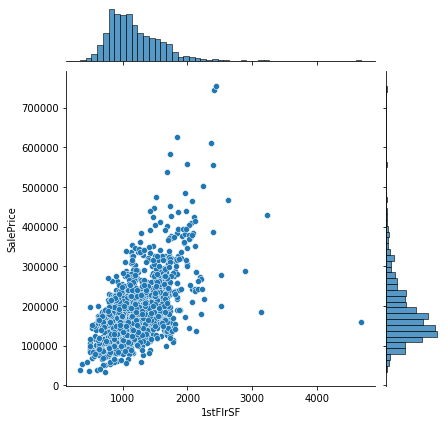

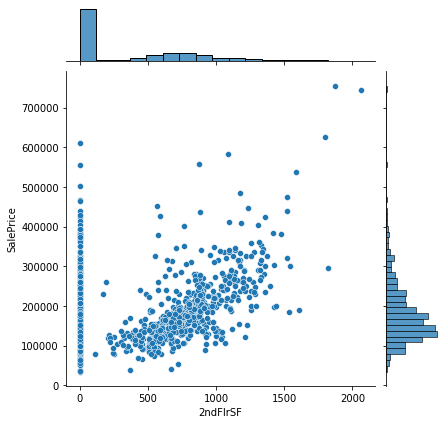

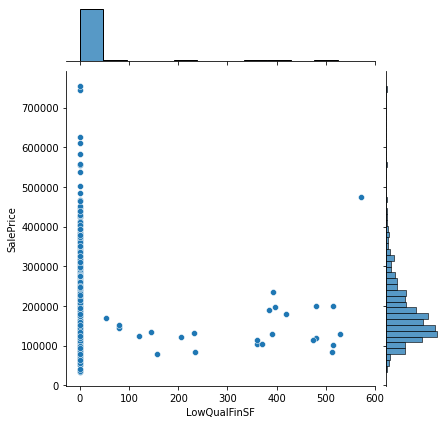

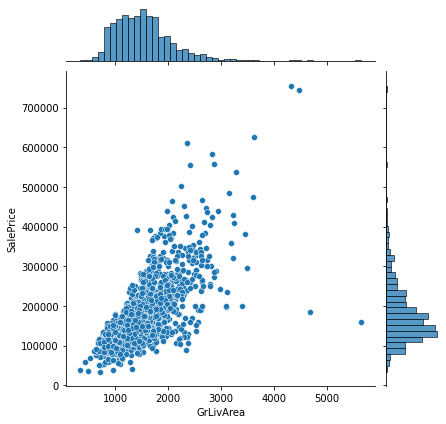

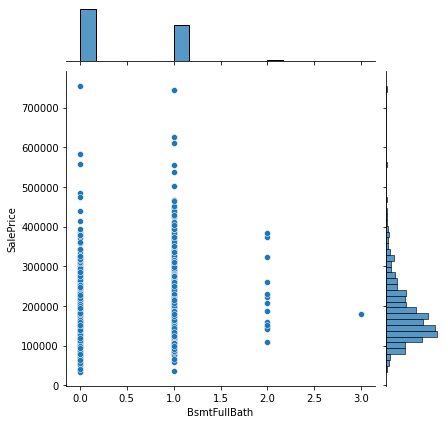

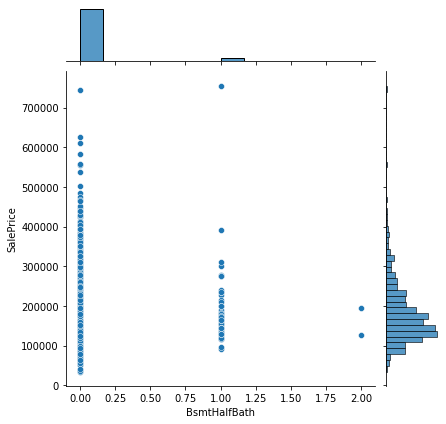

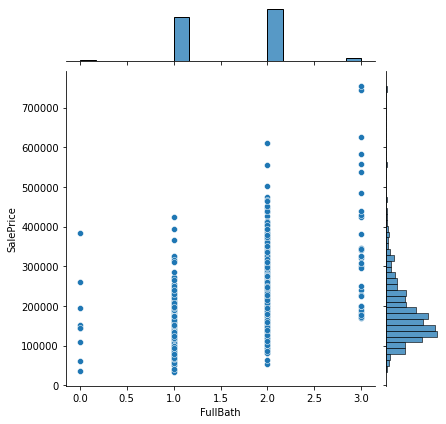

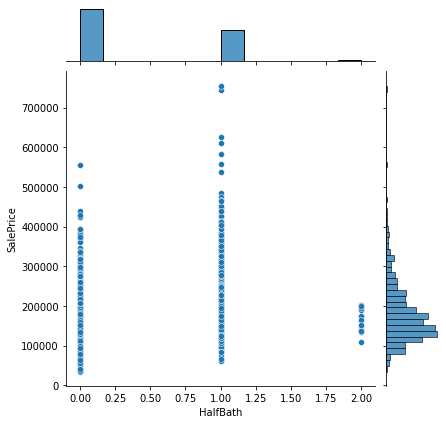

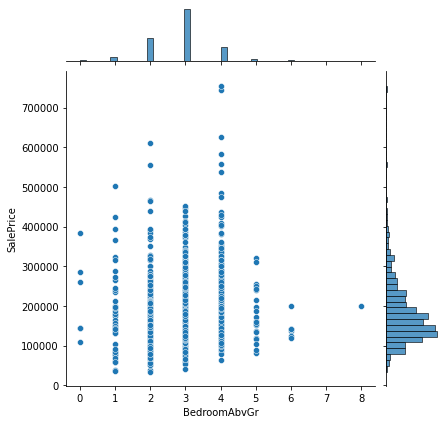

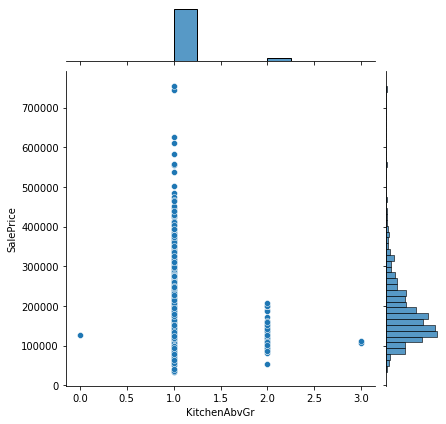

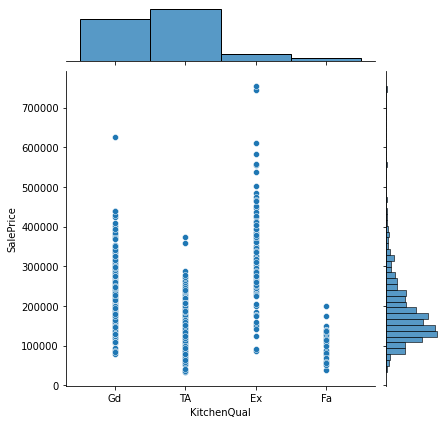

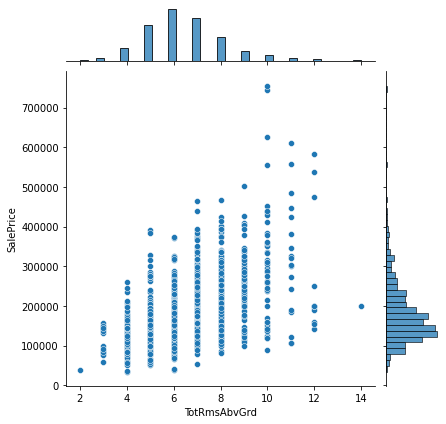

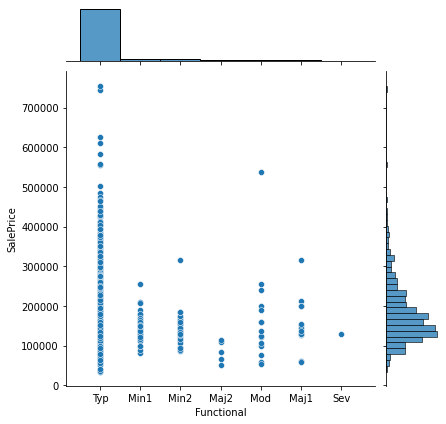

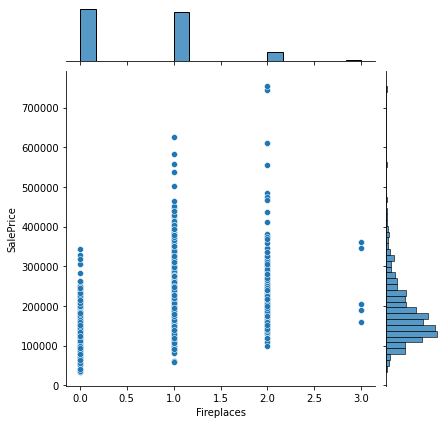

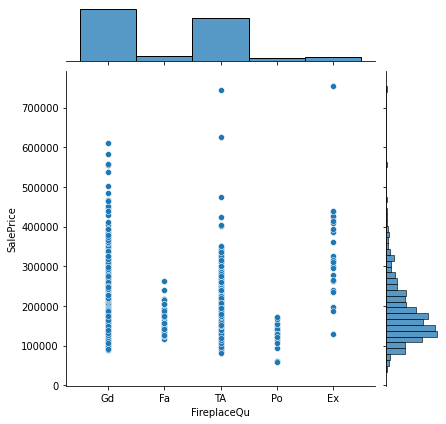

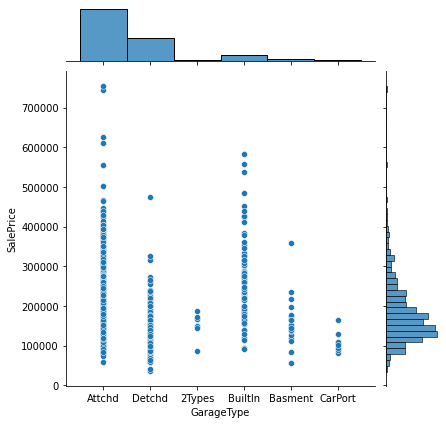

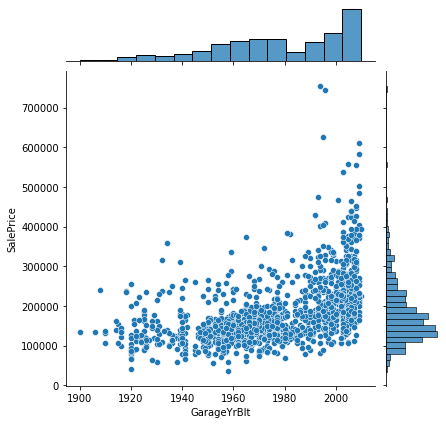

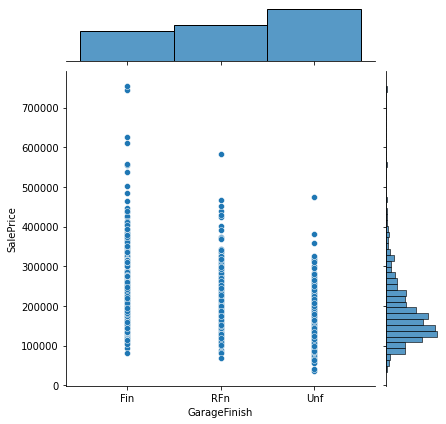

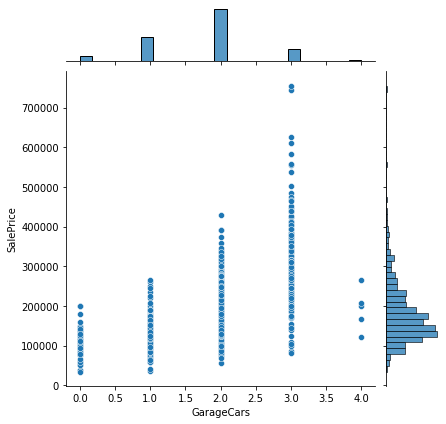

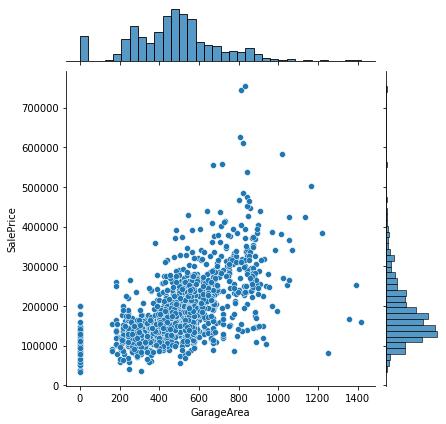

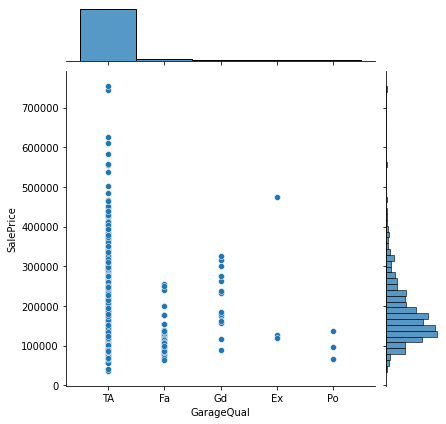

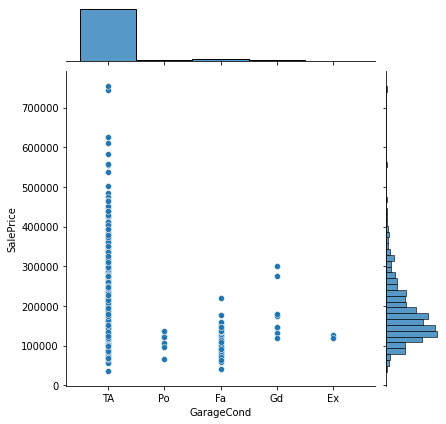

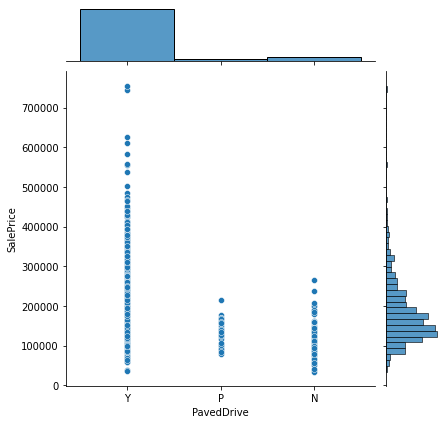

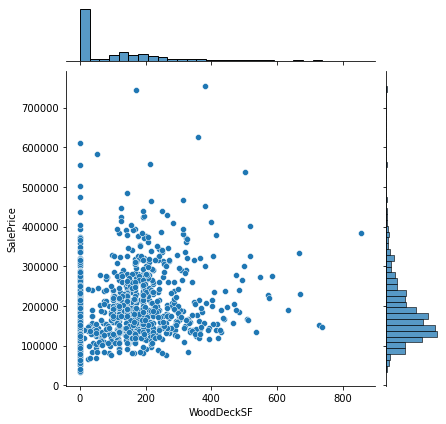

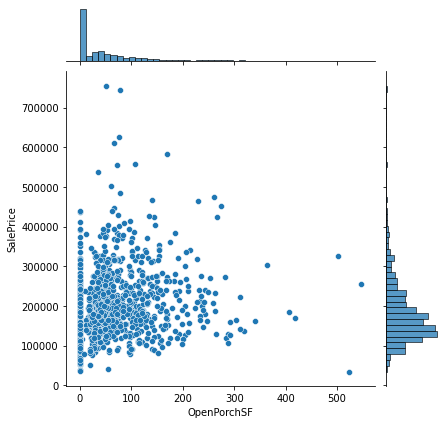

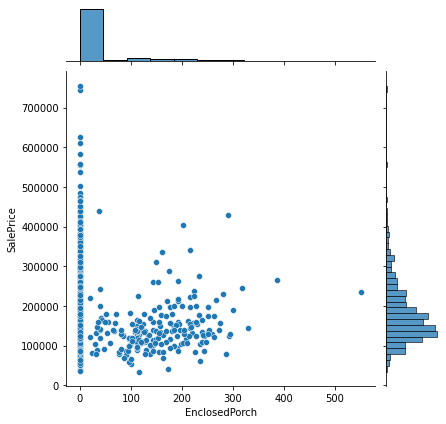

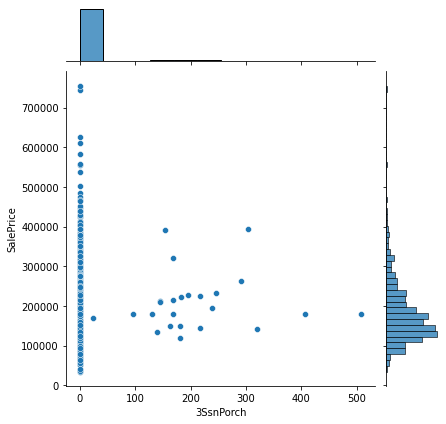

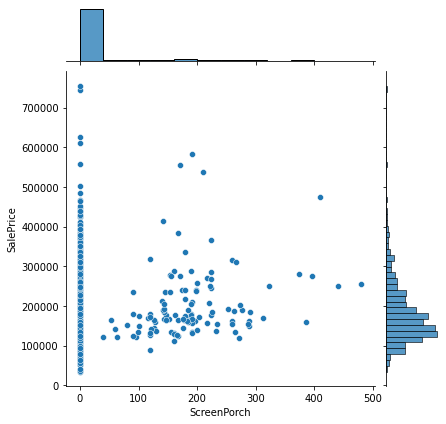

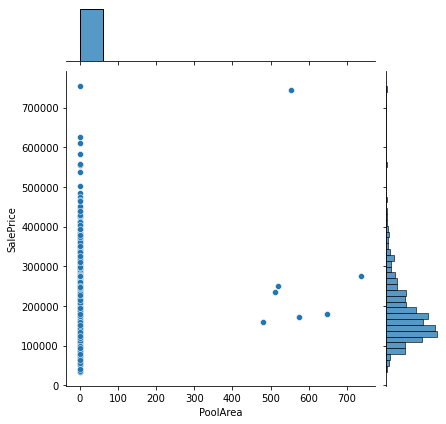

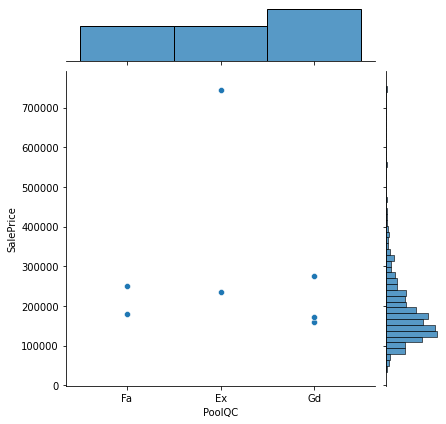

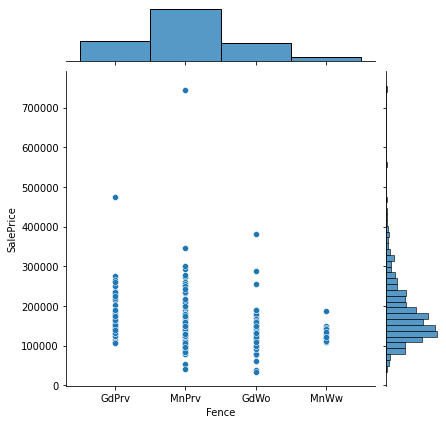

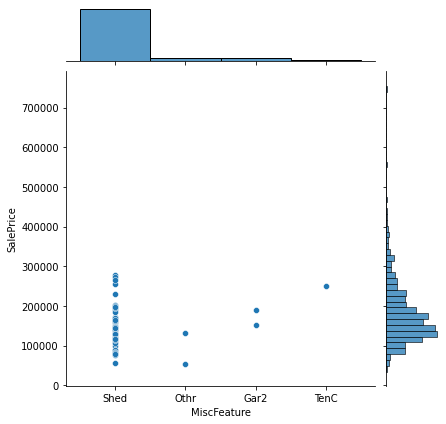

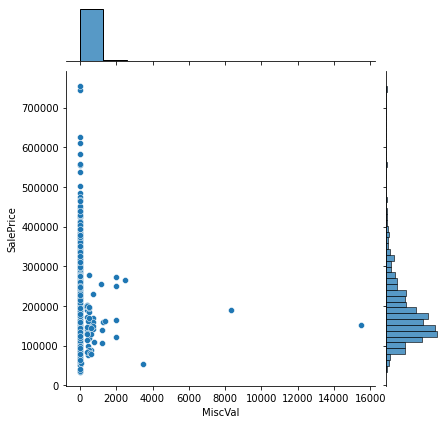

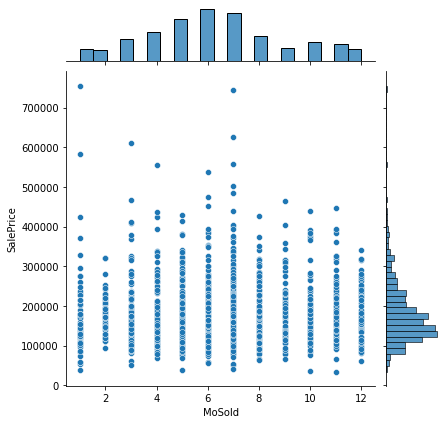

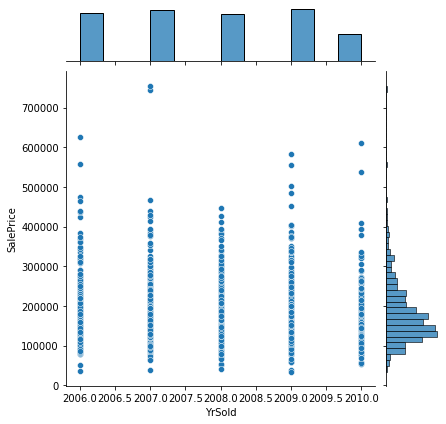

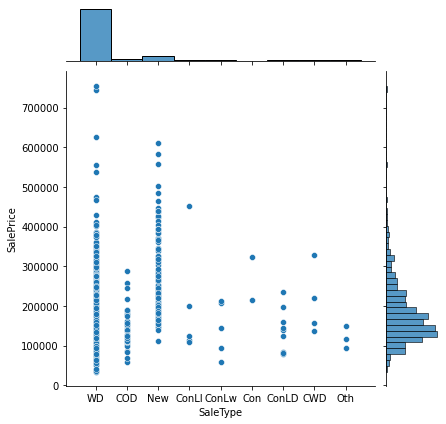

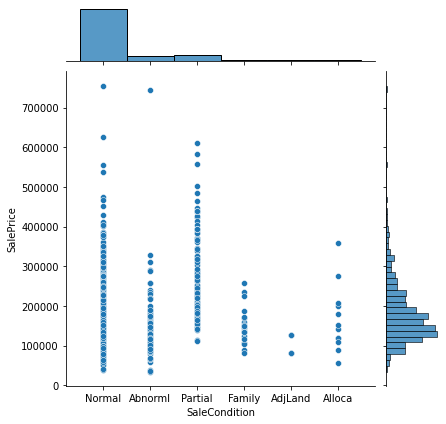

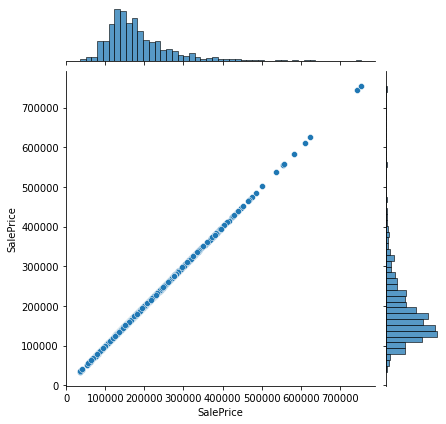

In [109]:
feats = train_set.columns
other_feats = []

for feat in feats:
    try:
        sns.jointplot(data=pd.concat([train_set, test_set]), y="SalePrice", x=feat)
        plt.show()
        #train_set.plot.scatter(x=feat, y='SalePrice', alpha=0.1)
    except:
        other_feats.append(feat)
            

In [47]:
print(other_feats)

['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [9]:
train_set['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

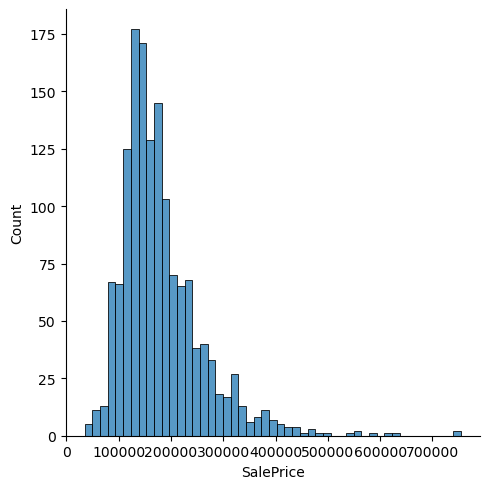

In [16]:
sns.displot(train_set['SalePrice'])

In [8]:
selected_features = [
    'MSSubClass', 'MSZoning', 'LandContour', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'OverallQual', 'OverallCond', 'YearRemodAdd',
    'ExterQual', 'ExterCond', 'Foundation', 'TotalBsmtSF',
    'HeatingQC', 'CentralAir', 'GrLivArea', 'BsmtFullBath',
    'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
    'KitchenQual', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
    'MiscVal', 'SaleCondition'
]

In [133]:
X_train = train_set[selected_features]
y_train = np.log1p(train_set['SalePrice'])

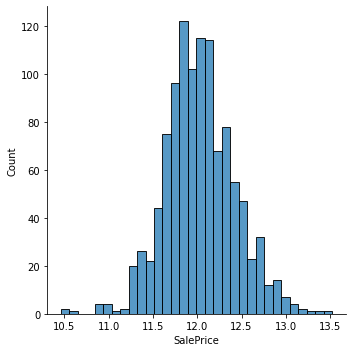

In [69]:
sns.displot(y_train)

By taking the log we have labels that look much more like a normal distribution. We are also told to minimize the MSLE instead of the MSE.

## Data preprocessing

In [111]:
num_attr = ['YearRemodAdd', 'GrLivArea', 'FullBath', 'HalfBath',
            'BedroomAbvGr', 'TotRmsAbvGrd']
num_nul_attr = ['TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
cat_attr = ['MSZoning', 'LandContour', 'Neighborhood',
            'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
            'Foundation', 'MiscVal', 'SaleCondition', 'MSSubClass',
            'CentralAir']
qual_attr = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual',
             'OverallQual', 'OverallCond']

In [138]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, validate=True),
    StandardScaler()
)

num_nul_pipeline = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0.),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

qual_pipeline = lambda n_features : make_pipeline(
    SimpleImputer(strategy="constant", fill_value='Fa'),
    OrdinalEncoder(categories=[['Ex', 'Gd', 'TA', 'Fa', 'Po']] * n_features, 
                handle_unknown='use_encoded_value', 
                unknown_value=-1),
    StandardScaler()
)

In [139]:
column_trans = make_column_transformer(
    (num_pipeline, num_attr),
    (num_nul_pipeline, num_nul_attr),
    (cat_pipeline, cat_attr),
    (qual_pipeline(len(qual_attr)), qual_attr)
)

In [168]:
Xt_train = column_trans.fit_transform(X_train)

In [169]:
X_pred = predict_set[selected_features]
Xt_pred = column_trans.transform(X_pred)

In [170]:
def make_submission(predictors, filename):
    # ensemble
    log_pred = sum([predictor.predict(Xt_pred) for predictor in predictors]) / len(predictors)
    pred = np.expm1(log_pred)
    predictions = pd.DataFrame({
        'Id': range(1461, 1461+predict_set.shape[0]),
        'SalePrice': pred
    })
    predictions.to_csv('submission_' + filename + '.csv', index=False)

## Models

### Decision Trees

In [151]:
dtr = DecisionTreeRegressor()

In [157]:
cross_val_score(dtr, Xt_train, y_train, cv=5).mean()

0.6822340617787981

Let's try **RandomForest**

In [158]:
rfr = RandomForestRegressor()

In [159]:
cross_val_score(rfr, Xt_train, y_train, cv=5).mean()

0.8523926320592577

Much better, let's try to tune the hyperparameters

In [160]:
param_grid = { 
    'n_estimators': [50, 100, 200, 300],
    'max_features': [1., 'sqrt', 'log2'],
    'max_depth' : [6,8,10,None]
}

In [161]:
CV_rfc = GridSearchCV(estimator=rfr, param_grid=param_grid,
                      cv=5, scoring='neg_mean_squared_error')
CV_rfc.fit(Xt_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [6, 8, 10, None],
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='neg_mean_squared_error')

In [164]:
CV_rfc.best_params_

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

In [165]:
rfr = RandomForestRegressor(max_depth=None, max_features='sqrt', n_estimators=100)

In [166]:
rfr.fit(Xt_train, y_train)

RandomForestRegressor(max_features='sqrt')

Let's try to predict for submission

In [219]:
make_submission([rfr], 'randomforest')

Let's now try boosting

In [213]:
xgbr = xg.XGBRegressor(learning_rate=0.01,n_estimators=2000,
                       subsample=0.7,colsample_bytree=0.7)

In [214]:
cross_val_score(xgbr, Xt_train, y_train, cv=5).mean()

0.880845407792758

In [225]:
xgbr.fit(Xt_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [226]:
make_submission([xgbr], 'xgbr')

## SVMs

In [172]:
svr = SVR()

In [173]:
cross_val_score(svr, Xt_train, y_train, cv=5).mean()

0.8613002253863667

Let's tune parameters

In [176]:
param_grid = { 
    'C': np.arange(0.1, 1.1, 0.1),
    'kernel': ['rbf', 'sigmoid'],
}

In [177]:
CV_svr = GridSearchCV(estimator=svr, param_grid=param_grid,
                      cv=5, scoring='neg_mean_squared_error')
CV_svr.fit(Xt_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'kernel': ['rbf', 'sigmoid']},
             scoring='neg_mean_squared_error')

In [178]:
CV_svr.best_params_

{'C': 0.9, 'kernel': 'rbf'}

In [179]:
svr = svm.SVR(C=0.9)

In [180]:
svr.fit(Xt_train, y_train)

SVR(C=0.9)

In [181]:
make_submission([svr], 'svr')

## Kernel + Ridge

In [197]:
kr = KernelRidge(kernel='polynomial')

In [198]:
cross_val_score(kr, Xt_train, y_train, cv=5).mean()

0.8561082412567101

Let's tune parameters

In [199]:
param_grid = { 
    'alpha': np.arange(0.5, 2.3, 0.2),
    'kernel': ['rbf', 'polynomial', 'laplacian'],
}

In [200]:
CV_kr = GridSearchCV(estimator=kr, param_grid=param_grid,
                      cv=5, scoring='neg_mean_squared_error')
CV_kr.fit(Xt_train, y_train)

GridSearchCV(cv=5, estimator=KernelRidge(kernel='polynomial'),
             param_grid={'alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1]),
                         'kernel': ['rbf', 'polynomial', 'laplacian']},
             scoring='neg_mean_squared_error')

In [205]:
CV_kr.best_params_

{'alpha': 0.5, 'kernel': 'polynomial'}

In [206]:
kr = KernelRidge(alpha=0.5, kernel='polynomial')

In [207]:
kr.fit(Xt_train, y_train)

KernelRidge(alpha=0.5, kernel='polynomial')

In [209]:
make_submission([kr], 'kr')

## Ensemble

In [220]:
make_submission([kr, svr, rfr, xgbr], 'ensemble')